## Regression of Edmunds Consumer Car Dataset

Dataset Source: https://www.kaggle.com/datasets/ankkur13/edmundsconsumer-car-ratings-and-reviews

#### Install Necessary Libraries

In [1]:
%pip install torch transformers accelerate
%pip install -U scikit-learn
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00


#### HuggingFace Access Login

In [2]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


#### Import Necessary Libraries

In [3]:
import sys, os
os.environ['TOKENIZERS_PARALLELISM']='false'

import glob

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

import transformers
from transformers import AutoTokenizer, Trainer, TrainingArguments, set_seed
from transformers import AutoModelForSequenceClassification, get_scheduler

import datasets
from datasets import Dataset, DatasetDict

!git lfs install

Git LFS initialized.


#### Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Display Library Versions

In [5]:
print("Python :".rjust(18), sys.version[0:6])
print("NumPy :".rjust(18), np.__version__)
print("Pandas :".rjust(18), pd.__version__)
print("Torch :".rjust(18), torch.__version__)
print("Transformers :".rjust(18), transformers.__version__)
print("Datasets :".rjust(18), datasets.__version__)
print("Sklearn :".rjust(18), sklearn.__version__)

          Python : 3.10.1
           NumPy : 1.22.4
          Pandas : 1.5.3
           Torch : 2.0.1+cu118
    Transformers : 4.31.0
        Datasets : 2.14.2
         Sklearn : 1.3.0


### Data Ingestion & Preprocessing

#### Make Sure File Names are Named Consistently

In [6]:
data_folder = "/content/drive/MyDrive/NLP Regression/data/"

folder_name_start = "Scraped_Car_Review_"

folder_names = os.listdir(data_folder)
folder_name_start = "Scraped_Car_Review_"

for folder in folder_names:
    try:
        os.rename(data_folder + folder, data_folder + folder_name_start + folder.split("_")[-1])
    except FileNotFoundError:
        print(f"{folder} not found")

#### Data Ingestion

In [7]:
data_folder = "/content/drive/MyDrive/NLP Regression/data/"

all_files = glob.glob(os.path.join(data_folder, "*.csv"))

folder = '/content/drive/MyDrive/NLP Regression/data/Scraped_Car_Review_'

file_type=".csv"

fileset = [x for x in all_files]

col_names = ["INDEX",
             "REVIEW_DATE",
             "AUTHOR",
             "VEHICLE_TITLE",
             "Review_Title",
             "Review",
             "label"]

data_types = {"INDEX": str,
              "REVIEW_DATE": str,
              "AUTHOR": str,
              "VEHICLE_TITLE": str,
              "Review_Title": str,
              "Review": str,
              "label": str
            }

df = pd.concat((pd.read_csv(f, on_bad_lines="skip",
                            lineterminator='\n',
                            names=col_names,
                            dtype=data_types,
                            header=0) for f in fileset),
               ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226931 entries, 0 to 226930
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   INDEX          226931 non-null  object
 1   REVIEW_DATE    226931 non-null  object
 2   AUTHOR         226930 non-null  object
 3   VEHICLE_TITLE  226931 non-null  object
 4   Review_Title   226918 non-null  object
 5   Review         226931 non-null  object
 6   label          226931 non-null  object
dtypes: object(7)
memory usage: 12.1+ MB


#### Data Preprocessing (Part 1)

In [8]:
# drop duplicate reviews
df.drop_duplicates(inplace=True)

# Features to drop, if they still are included in the dataframe
# First check which of these columns still remain
cols_to_check = ["VEHICLE_TITLE", "INDEX", "REVIEW_DATE", "AUTHOR"]
cols_to_drop = []
for x in cols_to_check:
    if x in df.columns:
        cols_to_drop.append(x)

# Second, remove columns that do remain
df.drop(columns=cols_to_drop, inplace=True)

# Since there are only 13 missing values (all of which are titles)
# out of 226,000+ samples, I will drop those samples
review_title_feature = "Review_Title"
if review_title_feature in df.columns:
    df.dropna(axis=0, subset=[review_title_feature], inplace=True)

# concatenate the review title and text using ' : ' as the seperator
df["text"] = df["Review_Title"] + " : " + df["Review"]

# Remove any leading & trailing whitespace
df['text'] = df['text'].apply(lambda x: x.strip())
df['label'] = df['label'].apply(lambda x: x.strip())

# remove the trailing '/r' for each label value & convert
# to float32 data type
df['label'] = df['label'].apply(lambda x: x.rstrip('/r'))\
    .astype(np.float32)

df

,Review_Title,Review,label,text
0,2006 Mustang GT,Doesn’t disappoint,5.000,2006 Mustang GT : Doesn’t disappoint
1,DREAM CAR,I bought mine 4/17 with 98K. Have been wantin...,3.000,DREAM CAR : I bought mine 4/17 with 98K. Have...
2,Great Ride,There will always be a 05-09 mustang for sale...,5.000,Great Ride : There will always be a 05-09 mus...
3,I have wanted a Mustang for 40 years.,I bought my car from an auction I work at ( A...,5.000,I have wanted a Mustang for 40 years. : I bou...
4,One owner,I bought this car spankin new and i still am ...,5.000,One owner : I bought this car spankin new and...
...,...,...,...,...
226926,Excellent Car,This is a very relaible car...and very \rfun ...,5.000,Excellent Car : This is a very relaible car.....
226927,Handles great and looks good too!,This is a first-rate car. I can be \rconfiden...,4.875,Handles great and looks good too! : This is a...
226928,"Fun, reliable, sporty","After four years, this car has never \rhad a ...",4.500,"Fun, reliable, sporty : After four years, thi..."
226929,good overall with one exception,Overall I am happy with the '99 Celica GT.\rT...,4.625,good overall with one exception : Overall I a...


#### Data Preprocessing (Part 2)

In [9]:
# Drop 'Review_Title' & 'Review' as they were
# concatenated into new feature
cols_to_check = ["Review_Title", "Review"]
cols_to_drop = []

for x in cols_to_check:
    if np.any(x in df.columns):
        if np.any("text" in df.columns):
            cols_to_drop.append(x)

df = df.drop(columns=cols_to_drop)

df

,label,text
0,5.000,2006 Mustang GT : Doesn’t disappoint
1,3.000,DREAM CAR : I bought mine 4/17 with 98K. Have...
2,5.000,Great Ride : There will always be a 05-09 mus...
3,5.000,I have wanted a Mustang for 40 years. : I bou...
4,5.000,One owner : I bought this car spankin new and...
...,...,...
226926,5.000,Excellent Car : This is a very relaible car.....
226927,4.875,Handles great and looks good too! : This is a...
226928,4.500,"Fun, reliable, sporty : After four years, thi..."
226929,4.625,good overall with one exception : Overall I a...


#### Visulatization: Distribution of Review Values

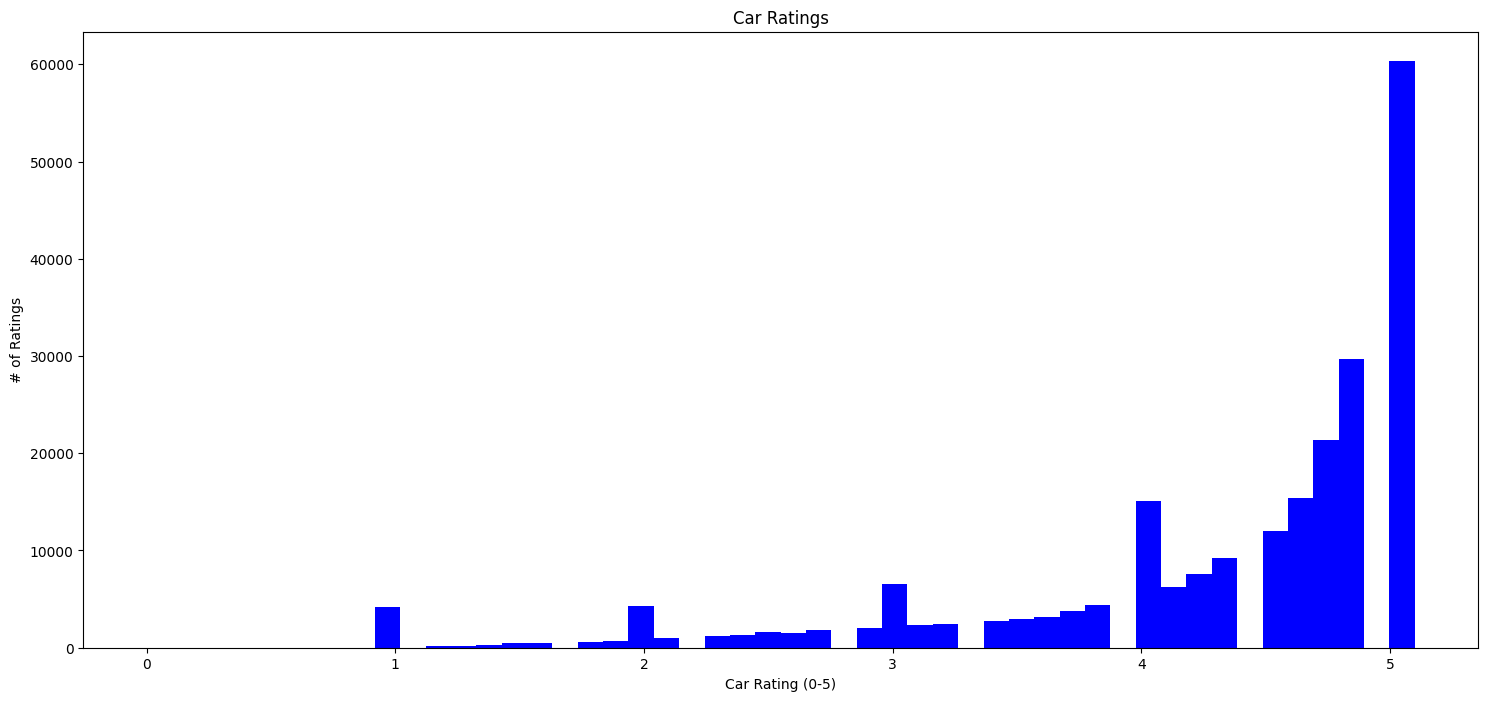

In [10]:
df.hist("label",
        color="Blue",
        grid=False,
        bins=50,
        figsize=(18,8),
        range=(0,5.1)
        )

plt.suptitle('')
plt.title('Car Ratings')
plt.xlabel('Car Rating (0-5)')
plt.ylabel('# of Ratings')
plt.show()

#### Visualization of Input Length

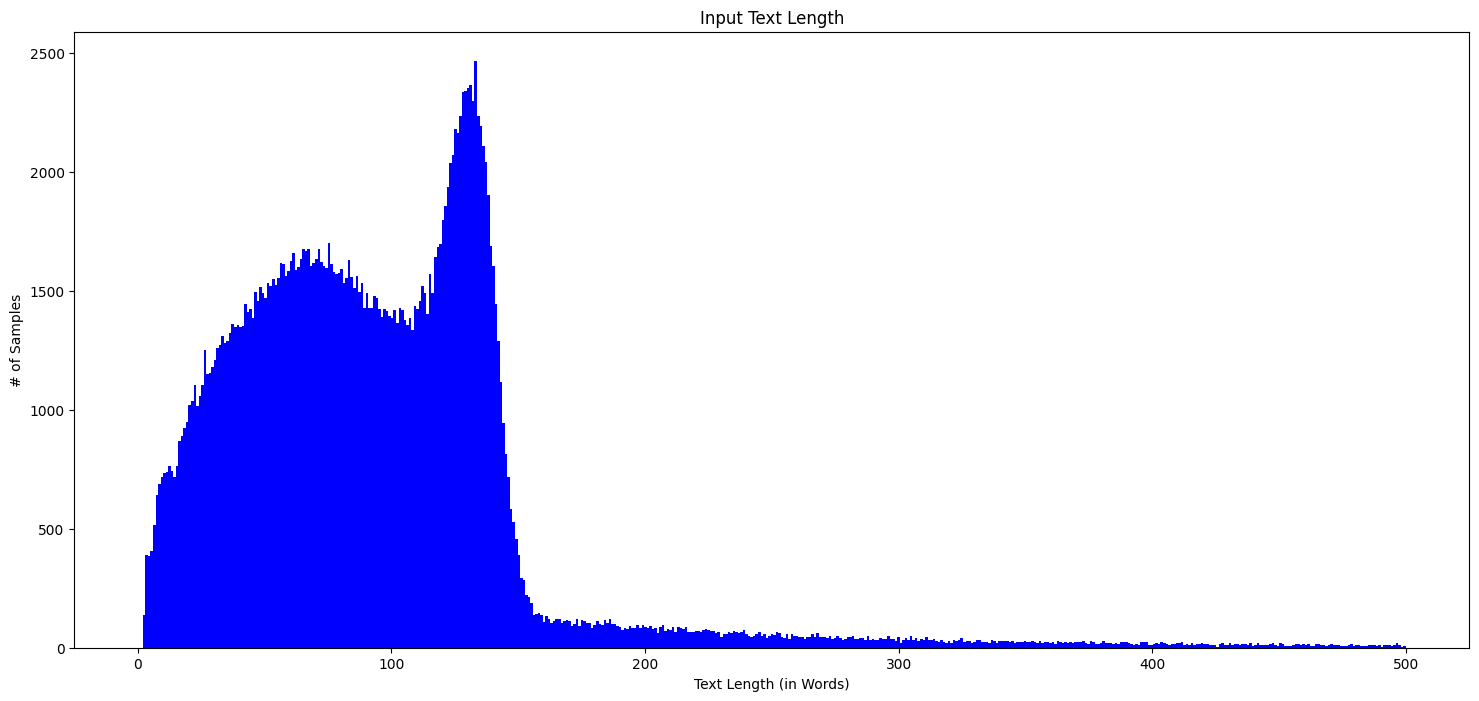

The longest input text is approximately 1521 words.


In [11]:
df['text_len'] = df['text'].str.split().apply(len)

n = 500
df.hist("text_len", color="Blue", grid=False, bins=n + 1, range=(0,n), figsize=(18,8))
plt.title("Input Text Length")
plt.suptitle('')
plt.xlabel('Text Length (in Words)')
plt.ylabel('# of Samples')
plt.show()

print(f"The longest input text is approximately {max(df['text_len'])} words.")

#### Drop Unnecessary Features & Trim Overly Lengthy Reviews

In [12]:
df = df[df["text_len"] < 109]

df.drop(columns=["text_len"], inplace=True)

df.count()

<ipython-input-12-ba83c981ed61>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["text_len"], inplace=True)


label    140668
text     140668
dtype: int64

### Actual Project

#### Convert DataFrame to Dataset & Split Dataset into Training & Evaluation Datasets

In [13]:
dataset = Dataset.from_pandas(df)

train_eval = dataset.train_test_split(test_size=0.35)

ds = DatasetDict({
    'train' : train_eval['train'],
    'eval' : train_eval['test']
})

print('Training data shape:', ds['train'].shape)
print('Eval data shape:', ds['eval'].shape)

Training data shape: (91434, 3)
Eval data shape: (49234, 3)


##### Basic Values

In [14]:
NUM_OF_EPOCHS = 3
MODEL_CKPT = "bert-base-uncased"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_LABELS = 1

BATCH_SIZE = 64
MODEL_NAME = f"{MODEL_CKPT}-Regression-Edmunds_Car_Reviews"

LEARNING_RATE = 2e-5
REPORTS_TO = "tensorboard"
set_seed(42)

#### Tokenize Entire Dataset

In [15]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(batch['text'],
                     truncation=True
                     )

encoded_ds = ds.map(tokenize,
                    batched=True,
                    batch_size=None)

print(encoded_ds['train'].features)
print(encoded_ds['train'])

Map:   0%|          | 0/91434 [00:00<?, ? examples/s]

Map:   0%|          | 0/49234 [00:00<?, ? examples/s]

{'label': Value(dtype='float32', id=None), 'text': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None), 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None), 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None), 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}
Dataset({
    features: ['label', 'text', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 91434
})


#### Initialize Model

In [16]:
model = (
    AutoModelForSequenceClassification.from_pretrained(MODEL_CKPT,
                                                       num_labels=NUM_LABELS
                                                       )
    ).to(DEVICE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Metrics Evaluation Function

In [17]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)

    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)

    return {"mse": mse, "rmse": rmse, "mae": mae}

#### Trainer Arguments

In [18]:
training_args = TrainingArguments(output_dir=MODEL_NAME,
                                  num_train_epochs=NUM_OF_EPOCHS,
                                  auto_find_batch_size=True,
                                  weight_decay=0.01,
                                  learning_rate=LEARNING_RATE,
                                  evaluation_strategy='epoch',
                                  logging_strategy='steps',
                                  logging_steps=200,
                                  logging_first_step=True,
                                  load_best_model_at_end=True,
                                  metric_for_best_model='mae',
                                  report_to=REPORTS_TO,
                                  greater_is_better=False,
                                  group_by_length=True,
                                  save_strategy='epoch',
                                  hub_private_repo=True,
                                  push_to_hub=True)

####  Build Trainer

In [19]:
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=encoded_ds['train'],
                  eval_dataset=encoded_ds['eval'],
                  tokenizer=tokenizer,
                  compute_metrics=compute_metrics)

Cloning https://huggingface.co/DunnBC22/bert-base-uncased-Regression-Edmunds_Car_Reviews into local empty directory.


#### Train Trainer

In [20]:
training_results = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae
1,0.214200,0.242073,0.242073,0.492010,0.312643
2,0.193100,0.252996,0.252996,0.502987,0.333634
3,0.119200,0.232351,0.232351,0.482028,0.308900


#### Save Model & Metrics

In [21]:
trainer.save_model()
trainer.log_metrics("train", training_results.metrics)
trainer.save_metrics("train", training_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/418M [00:00<?, ?B/s]

Upload file runs/Aug01_22-49-17_3dba27098b3d/events.out.tfevents.1690930180.3dba27098b3d.562.0:   0%|         …

To https://huggingface.co/DunnBC22/bert-base-uncased-Regression-Edmunds_Car_Reviews
   ed509ff..2fbabad  main -> main

   ed509ff..2fbabad  main -> main

To https://huggingface.co/DunnBC22/bert-base-uncased-Regression-Edmunds_Car_Reviews
   2fbabad..4211bd3  main -> main

   2fbabad..4211bd3  main -> main



***** train metrics *****
  epoch                    =        3.0
  total_flos               = 10539549GF
  train_loss               =     0.1991
  train_runtime            = 1:54:10.46
  train_samples_per_second =     40.041
  train_steps_per_second   =      5.006


#### Push Model to Hub

In [22]:
trainer.push_to_hub(commit_message="All Dunn!!!")

To https://huggingface.co/DunnBC22/bert-base-uncased-Regression-Edmunds_Car_Reviews
   4211bd3..80d463c  main -> main

   4211bd3..80d463c  main -> main



'https://huggingface.co/DunnBC22/bert-base-uncased-Regression-Edmunds_Car_Reviews/commit/80d463c6fbd8aa9b608a54c4f4ceb8fd668172e9'

### Notes & Other Takeaways From This Project

****
- Compared to the distilbert version of this model, these metrics are about the same, which is disappointing. The chart below demonstrates that Meas Squared Error (and Root Mean Squared Error) were better with the distilbert version, but Mean Absolute Error was better with this (the bert-base) version of the  model.


| Metric Name | DistilBert Value | Bert Value |
|:-----:|:-----:|:-----:|
| Mean Squared Error (MSE) | 0.2232 | 0.2324 |
| Root Mean Squared Error (RMSE) | 0.4724 | 0.4820 |
| Mean Absolute Error (MAE) | 0.3150 | 0.3089 |

* All values in the above chart are rounded to the nearest ten-thousandth.
****

### Citation

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-1810-04805, author = {Jacob Devlin and Ming{-}Wei Chang and Kenton Lee and Kristina Toutanova}, title = {{BERT:} Pre-training of Deep Bidirectional Transformers for Language Understanding}, journal = {CoRR}, volume = {abs/1810.04805}, year = {2018}, url = {http://arxiv.org/abs/1810.04805}, archivePrefix = {arXiv}, eprint = {1810.04805}, timestamp = {Tue, 30 Oct 2018 20:39:56 +0100}, biburl = {https://dblp.org/rec/journals/corr/abs-1810-04805.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}